In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix)
import lightgbm as lgb

In [6]:
# load data
df1 = pd.read_csv(r"c:\Users\Lenovo\Desktop\MOF_H2\MOF_catalysis\Data\Train\all_descriptor.csv")
df2 = pd.read_csv(r'c:\Users\Lenovo\Desktop\MOF_H2\MOF_catalysis\Data\Train\H2_production_rate_target.csv')
X = df1.iloc[:, 3:]
selected_features = joblib.load(r'c:\Users\Lenovo\Desktop\MOF_H2\MOF_catalysis\Model\selected_features.pkl')

percentile_65 = df2["H2_production_rate"].quantile(0.65)
y = np.where(df2["H2_production_rate"] < percentile_65, 0, 1)

In [11]:
# split data
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_full[selected_features])
X_test = scaler.transform(X_test_full[selected_features])
# save
# joblib.dump(scaler, 'scaler.pkl')
# model
model = lgb.LGBMClassifier(random_state=42, verbosity=-1)
param_grids = {
        'n_estimators': [50,100, 150],
        'learning_rate': [0.05, 0.1,0.12],
        'max_depth': [5,6,7,10]   
}

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grids, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
# save model
# joblib.dump(best_model, 'LightGBM_best_model.pkl')

y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:, 1]

y_pred_train = best_model.predict(X_train)
y_proba_train = best_model.predict_proba(X_train)[:, 1]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [8]:
results = {
    "Test F1": f1_score(y_test, y_pred_test),
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "test Precision": precision_score(y_test, y_pred_test),
    "Test Recall": recall_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_proba_test),
    }

# print result
print("\nModel Evaluation (LightGBM):")
for metric_name, value in results.items():
    if metric_name == "Best Params":
        print(f"  {metric_name}: {value}")
    else:
        print(f"  {metric_name}: {value:.3f}")


Model Evaluation (LightGBM):
  Test F1: 0.833
  Test Accuracy: 0.884
  test Precision: 0.833
  Test Recall: 0.833
  Test AUC: 0.876


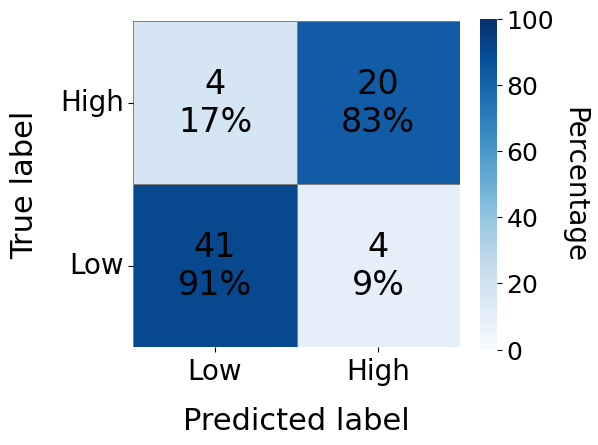

In [9]:
cm = confusion_matrix(y_test, y_pred_test)
support = cm.sum(axis=1)
cm_percent = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100)
cm_display = [[f"{int(cm[j, k])}\n{int(cm_percent[j, k])}%" for k in range(cm.shape[1])] for j in range(cm.shape[0])]

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm_percent, annot=cm_display, fmt='', cmap='Blues',
                     xticklabels=["Low", "High"], yticklabels=["Low", "High"],
                     cbar_kws={'label': 'Percentage', 'shrink': 0.85}, annot_kws={"size": 24, "color": "black"}, square=True,vmin=0, vmax=100,linewidths=0.5, linecolor='grey')
ax.collections[0].colorbar.ax.tick_params(labelsize=14)
ax.collections[0].colorbar.set_label('Percentage', fontsize=16, rotation=-90, labelpad=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20, rotation=0)  
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20, rotation=0)
ax.set_xlabel('Predicted label', fontsize=22, labelpad=15)
ax.set_ylabel('True label', fontsize=22, labelpad=15)
cbar = ax.collections[-1].colorbar
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Percentage', size=20, rotation=-90, labelpad=25)
ax.invert_yaxis()
plt.tight_layout()
plt.show()
